# e2e examples

In this notebook we will show how to compute a lognormal, apply and assess quality of reconstruction.

In [1]:
import os
import tempfile

import numpy as np
from matplotlib import pyplot as plt

# For mockfactory installation, see https://github.com/adematti/mockfactory
from mockfactory import EulerianLinearMock, LagrangianLinearMock, utils, setup_logging
# For cosmoprimo installation, see https://cosmoprimo.readthedocs.io/en/latest/user/building.html
from cosmoprimo.fiducial import DESI

from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, PlaneParallelFFTReconstruction
# For pypower installation, see https://github.com/adematti/pypower
from pyrecon.metrics import MeshFFTCorrelator, MeshFFTPropagator, CatalogMesh

# Set up logging
setup_logging()
z = 1.
# Load DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
f = cosmo.sigma8_z(z=z,of='theta_cb')/cosmo.sigma8_z(z=z,of='delta_cb') # growth rate

## Lognormal mock in box

In [2]:
bias, nbar, nmesh, boxsize, boxcenter, los = 2.0, 1e-3, 128, 1000., 0., 'x'

mock = LagrangianLinearMock(power, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=42, unitary_amplitude=False)
# This is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias-1)
mesh_real = mock.mesh_delta_r + 1.
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=43)
mock.set_rsd(f=f, los=los)
data = mock.to_catalog()
offset = data.boxcenter - data.boxsize/2.
data['Position'] = (data['Position'] - offset) % data.boxsize + offset

ReconstructionAlgorithm = MultiGridReconstruction
#ReconstructionAlgorithm = IterativeFFTReconstruction
#ReconstructionAlgorithm = PlaneParallelFFTReconstruction
recon = ReconstructionAlgorithm(f=f, bias=bias, los=los, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, fft_engine='fftw')
recon.assign_data(data.gget('Position'))
recon.set_density_contrast()
# Run reconstruction
recon.run()

[000001.36] [0/1] 11-30 21:33  LagrangianLinearMock      INFO     White noise generated
[000001.82] [0/1] 11-30 21:33  LagrangianLinearMock      INFO     Poisson sampling done, total number of objects is 1000513.
[000002.09] [0/1] 11-30 21:33  LagrangianLinearMock      INFO     Catalog produced. Assigning in cell shift.
[000004.47] [0/1] 11-30 21:33  MultiGridReconstruction   INFO     Using mesh RealMesh(boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.], nmesh=[128 128 128], dtype=float64).
[000004.78] [0/1] 11-30 21:33  MultiGridReconstruction   INFO     Computing displacement potential.


In [3]:
from mockfactory.make_survey import RandomBoxCatalog
randoms = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=44)

data['Position_rec'] = data['Position'] - recon.read_shifts(data['Position'], field='disp+rsd')
randoms['Position_rec'] = randoms['Position'] - recon.read_shifts(randoms['Position'], field='disp')
offset = data.boxcenter - data.boxsize/2.
for catalog in [data, randoms]:
    catalog['Position_rec'] = (catalog['Position_rec'] - offset) % catalog.boxsize + offset

mesh_recon = CatalogMesh(data['Position_rec'], randoms_positions=randoms['Position'],
                         boxsize=boxsize, boxcenter=boxcenter, nmesh=nmesh, resampler='cic', interlacing=2, position_type='pos')

kedges = np.arange(0.005, 0.4, 0.005)
muedges = np.linspace(-1., 1., 5)
correlator = MeshFFTCorrelator(mesh_recon, mesh_real, edges=(kedges, muedges), los=los)

[000007.06] [0/1] 11-30 21:33  MeshFFTPower              INFO     Painting catalog 1 to mesh.
[000007.96] [0/1] 11-30 21:33  CatalogMesh               INFO     Running interlacing at order 2.
[000009.09] [0/1] 11-30 21:33  MeshFFTPower              INFO     Done painting catalog 1 to mesh.
[000009.09] [0/1] 11-30 21:33  MeshFFTPower              INFO     Running power spectrum estimation.
[000009.14] [0/1] 11-30 21:33  MeshFFTPower              INFO     Applying compensations ({'resampler': 'cic', 'shotnoise': False},).
[000009.34] [0/1] 11-30 21:33  MeshFFTPower              INFO     Power spectrum computed in elapsed time 0.25 s.
[000009.34] [0/1] 11-30 21:33  MeshFFTPower              INFO     Painting catalog 1 to mesh.
[000010.19] [0/1] 11-30 21:33  CatalogMesh               INFO     Running interlacing at order 2.
[000011.17] [0/1] 11-30 21:33  MeshFFTPower              INFO     Done painting catalog 1 to mesh.
[000012.12] [0/1] 11-30 21:33  MeshFFTPower              INFO     Run

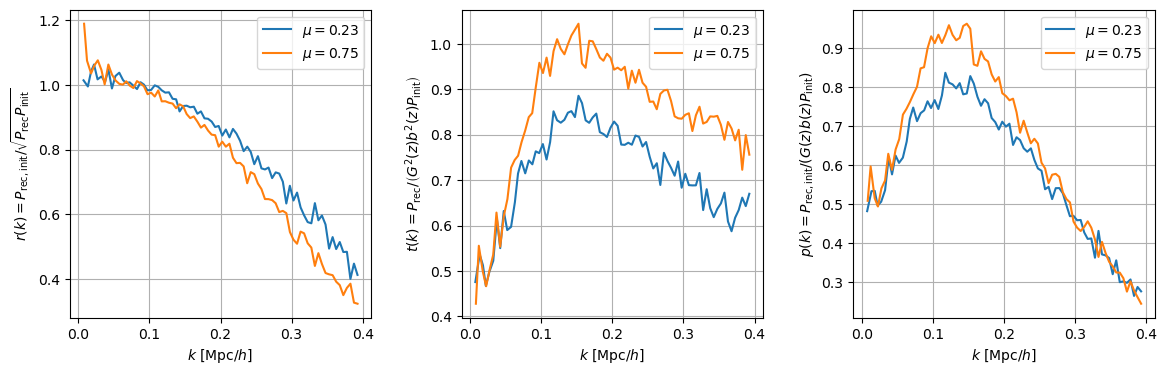

In [4]:
propagator = correlator.to_propagator(growth=bias)
transfer = correlator.to_transfer(growth=bias)
fig, lax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for mu in [0., 0.7]:
    k = correlator.k(mu=mu)
    mask = k < 0.4
    k = k[mask]
    mu = np.nanmean(correlator.mu(mu=mu)[mask])
    lax[0].plot(correlator.k(mu=mu)[mask], correlator(mu=mu)[mask], label=r'$\mu = {:.2f}$'.format(mu))
    lax[1].plot(transfer.k(mu=mu)[mask], transfer(mu=mu)[mask], label=r'$\mu = {:.2f}$'.format(mu))
    lax[2].plot(propagator.k(mu=mu)[mask], propagator(mu=mu)[mask], label=r'$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('$k$ [$\mathrm{Mpc}/h$]')
lax[0].set_ylabel(r'$r(k) = P_{\mathrm{rec},\mathrm{init}}/\sqrt{P_{\mathrm{rec}}P_{\mathrm{init}}}$')
lax[1].set_ylabel(r'$t(k) = P_{\mathrm{rec}}/\left(G^{2}(z) b^{2}(z) P_{\mathrm{init}}\right)$')
lax[2].set_ylabel(r'$p(k) = P_{\mathrm{rec},\mathrm{init}}/\left(G(z) b(z) P_{\mathrm{init}}\right)$')
plt.show()

In [5]:
# You can save the result (similarly for MeshFFTCorrelator and MeshFFTTransfer)
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    propagator.save(fn)
    # And reload the result
    propagator = MeshFFTPropagator.load(fn)
    print(propagator.edges[0])

[000013.29] [0/1] 11-30 21:33  MeshFFTPropagator         INFO     Saving /tmp/tmpuu4vob7d/tmp.npy.
[000013.30] [0/1] 11-30 21:33  MeshFFTPropagator         INFO     Loading /tmp/tmpuu4vob7d/tmp.npy.
[0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115 0.12
 0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175 0.18
 0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235 0.24
 0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295 0.3
 0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355 0.36
 0.365 0.37  0.375 0.38  0.385 0.39  0.395]
